This is a notebook that 
- prepares the era5 dataset with different blocking duration thresholds.  (X and Y)
- save them as  "/scratch/hz1994/blocking/data_era5/test_data_1940-2022_T%d.npy"%T and "/scratch/hz1994/blocking/data_era5/test_labels_1940-2022_T%d.npy"%T.

For example, T can be 5,7,9 which filters the datapoints which starts a blocking that lasts continuously more than 5 days, more than 7 days and more than 9 days. Later they will be

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import struct

import cartopy
from cartopy import crs as ccrs
import matplotlib 
from matplotlib import pyplot as plt
import os
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import pandas as pd
import matplotlib.path as mpath
from matplotlib.colors import TwoSlopeNorm 
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pickle
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import importlib.util
import pathlib
spec = importlib.util.spec_from_file_location("MM_dataprepare", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/MM_dataprepare.py")
MM_dataprepare = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_dataprepare
spec.loader.exec_module(MM_dataprepare)
spec = importlib.util.spec_from_file_location("MM_utilblocking", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/MM_utilblocking.py")
MM_utilblocking = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_utilblocking
spec.loader.exec_module(MM_utilblocking)

with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("Reduced_dim_variables"):
            rd_path=ln.strip().split('\t')[1]
        if ln.startswith("TMindex_filepath"):
            TMindex_path=ln.strip().split('\t')[1]   
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]   
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1]            
            
print(rd_path)
print(TMindex_path)
print(dim_path)
print(train_path)
print(models_path)
print(fig_path)

/ext3/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-24 19:56:34.455520: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 19:56:45.545496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:56:45.545573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:56:45.546128: 

/scratch/hz1994/blocking/data_MMmodel/reduceddim/
/scratch/hz1994/blocking/data_MMmodel/TMindex/
/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


# Load the data and create the committor values if there is no committor yet. Later they will be the input in Era5-extremecase-split-train_test_datasets-and-training-and-evaluation-withnotes.ipynb

In [7]:
M=150
T=9

compute_indicator=True
computeTk_committor=True
compute_committor_only=False
if compute_indicator:
    zprime_500_atl0=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/1940-1958/"+"Atlantic_zprime_"+"era5-"+"1940-1958"+"-z"+".nc")
    zprime_500_atl1=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/1959-2022/"+"Atlantic_zprime_"+"era5-"+"1959-2022"+"-z"+".nc")
    zprime_500_atl=xr.combine_by_coords([zprime_500_atl0, zprime_500_atl1])

    if computeTk_committor:
        MM_utilblocking.computeTkandCommittor(zprime_500_atl,'Atl',"era5-1940-2022",\
                                              "/scratch/hz1994/blocking/data_era5/",M,T,"T",a=None)
    if compute_committor_only:
        T_reg=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/Atl_Tk_era5-1940-2022.nc")
        MM_utilblocking.computeCommittor_only('Atl',T_reg,"era5-1940-2022",\
                                              "/scratch/hz1994/blocking/data_era5/",M,T,"T",a=None,zprime_reg=zprime_500_atl)

setA: T_reg==0
computed Tk, A, B, forward and backward for era5-1940-2022Atl and saved to /scratch/hz1994/blocking/data_era5/


# Create the dataset with the computed indicator 

In [16]:

T=9
computeT1data=True
if computeT1data:
    Forward=xr.open_dataset("/scratch/hz1994/blocking/data_era5/Atl_committor_M_150_T_%d_era5-1940-2022.nc"%T)['forward']
    T_reg=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/Atl_Tk_era5-1940-2022.nc")
    data0=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/1940-1958/era5-1940-1958-z_lowpass3dys.nc")
    data1=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/1959-2022/era5-1959-2022-z_lowpass3dys.nc")
    data=xr.combine_by_coords([data0, data1])
    
    X_T1=data['z'][T_reg.data==1]
    X_T1_DJF=X_T1.sel(time=X_T1.time.dt.month.isin([12,1,2]))
    Y_T1=Forward[T_reg.data==1] 
    Y_T1_DJF=Y_T1.sel(time=Y_T1.time.dt.month.isin([12,1,2]))
    
    data_std=X_T1_DJF.std(axis=0 )
    data_mean=X_T1_DJF.mean(axis=0 )
    data_preprocessed=(X_T1_DJF-data_mean)/data_std 

    np.save("/scratch/hz1994/blocking/data_era5/test_data_1940-2022.npy",data_preprocessed)
    np.save("/scratch/hz1994/blocking/data_era5/test_labels_1940-2022_T%d.npy"%T,Y_T1_DJF.data)

# Plot the distribution of blocking duration


Text(0.5, 1.0, 'Distribution of blocking state durations for ERA5 DJF data')

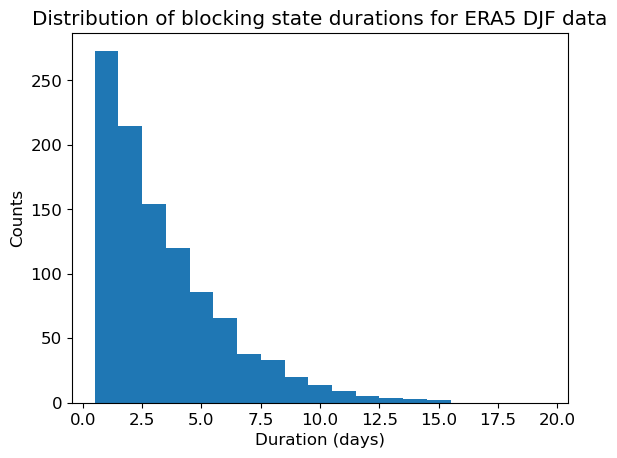

In [7]:

T_atl=xr.open_dataarray("/scratch/hz1994/blocking/data_era5/Atl_Tk_era5-1940-2022.nc")
T_atl_DJF=T_atl.sel(time=T_atl.time.dt.month.isin([12,1,2]))
fig,ax=plt.subplots()
h,b,p=ax.hist(T_atl_DJF.data,bins=np.arange(0.5,20.5,1))
ax.set_xlabel("Duration (days)")
ax.set_ylabel("Counts")
ax.set_title("Distribution of blocking state durations for ERA5 DJF data")

# Single frame data for oversampling during transfer learning

In [25]:
single_frame_path="/scratch/hz1994/blocking/data_era5/data1940-2022/"
data=np.load("/scratch/hz1994/blocking/data_era5/test_data_1940-2022.npy")
for ID in range(data.shape[0]):
    np.save(single_frame_path+'dataX_' + str(ID) + '.npy',data[ID])